In [55]:
# Imports

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

import warnings
warnings.filterwarnings("ignore")

# 1. Data

### Kiva.org Loans Listing

This dataset is from the Kiva API (https://build.kiva.org). More specifically, this is Kiva’s Loans Data Snapshot, which contains all the loan listings that Kiva has posted from 2006 till January 2018. The dataset contains 1.4M rows and 34 columns. Each listing contains information that shows the key details of a loan, including name, loan amount, loan description, sector, and so on.


The following variables from the dataset will be used: 


loans.csv

`|-- posted_time: the datetime the loan was posted on the Kiva.org website (datetime)
|-- original_description: the description of the loan in the language of the country the borrower is from (string)
|-- translated_description: the description of the loan translated to English if the original language is not English (string)
|-- sector: the specific category of the loan (categorical)`



In [2]:
NEW_names = ["LOAN_ID","LOAN_NAME","ORIGINAL_LANGUAGE","DESCRIPTION","DESCRIPTION_TRANSLATED","FUNDED_AMOUNT","LOAN_AMOUNT","STATUS","IMAGE_ID","VIDEO_ID","ACTIVITY_NAME","SECTOR_NAME","LOAN_USE","COUNTRY_CODE","COUNTRY_NAME","TOWN_NAME","CURRENCY_POLICY","CURRENCY_EXCHANGE_COVERAGE_RATE","CURRENCY","PARTNER_ID","POSTED_TIME","PLANNED_EXPIRATION_TIME","DISBURSE_TIME","RAISED_TIME","LENDER_TERM","NUM_LENDERS_TOTAL","NUM_JOURNAL_ENTRIES","NUM_BULK_ENTRIES","TAGS","BORROWER_NAMES","BORROWER_GENDERS","BORROWER_PICTURED","REPAYMENT_INTERVAL","DISTRIBUTION_MODEL"]
OLD_names = ['id','name','original_language','original_description','translated_description','funded_amount','loan_amount','status','image_id','video_id','activity','sector','use','country_code','country_name','town','currency_policy', 'currency_exchange_coverage_rate','currency','partner_id','posted_time','planned_expiration_time','disbursed_time','funded_time','term_in_months','lender_count','journal_entries_count','bulk_journal_entries_count','tags','borrower_names','borrower_genders','borrower_pictured','repayment_interval','distribution_model']
dic = {}
for (k,v) in zip(NEW_names, OLD_names):
    dic[k]=v

In [3]:
raw_data = pd.read_csv('loans.csv',
                   parse_dates=["POSTED_TIME", "PLANNED_EXPIRATION_TIME",
                               "DISBURSE_TIME", "RAISED_TIME"])
raw_data2 = raw_data.rename(columns=dic)

In [4]:
raw_data2.shape

(1419607, 34)

In [5]:
raw_data2.head().transpose()

,0,1,2,3,4
id,657307,657259,658010,659347,656933
name,Aivy,Idalia Marizza,Aasia,Gulmira,Ricky\t
original_language,English,Spanish,English,Russian,English
original_description,"Aivy, 21 years of age, is single and lives in ...","Doña Idalia, esta casada, tiene 57 años de eda...",Aasia is a 45-year-old married lady and she ha...,"Гулмире 36 лет, замужем, вместе с супругом вос...",Ricky is a farmer who currently cultivates his...
translated_description,NaN,"Idalia, 57, is married and lives with her husb...",NaN,Gulmira is 36 years old and married. She and ...,NaN
funded_amount,125,400,400,625,425
loan_amount,125,400,400,625,425
status,funded,funded,funded,funded,funded
image_id,1.51125e+06,1.50795e+06,1.51224e+06,1.51442e+06,1.50683e+06
video_id,NaN,NaN,NaN,NaN,NaN


# 2. Preprocess Data 

In [6]:
df = raw_data2[['posted_time', 'original_description', 'translated_description', 'sector']]

In [7]:
df.head()

,posted_time,original_description,translated_description,sector
0,2014-01-15 02:23:45,"Aivy, 21 years of age, is single and lives in ...",NaN,Retail
1,2014-01-14 20:23:20,"Doña Idalia, esta casada, tiene 57 años de eda...","Idalia, 57, is married and lives with her husb...",Clothing
2,2014-01-16 11:32:58,Aasia is a 45-year-old married lady and she ha...,NaN,Retail
3,2014-01-20 09:59:48,"Гулмире 36 лет, замужем, вместе с супругом вос...",Gulmira is 36 years old and married. She and ...,Agriculture
4,2014-01-14 05:46:21,Ricky is a farmer who currently cultivates his...,NaN,Agriculture


In [8]:
# Create new column: loan_description (translated by defatult, original if translated is missing)
df['loan_description'] = df['translated_description'] # Default, to be overwritten below
df.loc[df['loan_description'] != df['loan_description'], 'loan_description'] = df.original_description

In [9]:
df.head()

,posted_time,original_description,translated_description,sector,loan_description
0,2014-01-15 02:23:45,"Aivy, 21 years of age, is single and lives in ...",NaN,Retail,"Aivy, 21 years of age, is single and lives in ..."
1,2014-01-14 20:23:20,"Doña Idalia, esta casada, tiene 57 años de eda...","Idalia, 57, is married and lives with her husb...",Clothing,"Idalia, 57, is married and lives with her husb..."
2,2014-01-16 11:32:58,Aasia is a 45-year-old married lady and she ha...,NaN,Retail,Aasia is a 45-year-old married lady and she ha...
3,2014-01-20 09:59:48,"Гулмире 36 лет, замужем, вместе с супругом вос...",Gulmira is 36 years old and married. She and ...,Agriculture,Gulmira is 36 years old and married. She and ...
4,2014-01-14 05:46:21,Ricky is a farmer who currently cultivates his...,NaN,Agriculture,Ricky is a farmer who currently cultivates his...


In [10]:
df.describe(include='all')

,posted_time,original_description,translated_description,sector,loan_description
count,1419607,1376322,966929,1419607,1376322
unique,1415162,1372656,963356,15,1372725
top,2006-04-16 07:10:50,Ella tiene 29 anos de edad y habita en casa pr...,A sign seen on an automatic restroom hand drye...,Agriculture,A sign seen on an automatic restroom hand drye...
freq,207,18,24,345950,24
first,2006-04-16 07:10:50,NaN,NaN,NaN,NaN
last,2018-01-11 07:11:23,NaN,NaN,NaN,NaN


In [11]:
df_final = df[['posted_time', 'loan_description', 'sector']]

**Removing Missings**

In [12]:
pd.DataFrame({'NaNs': df_final.isnull().sum()})

,NaNs
posted_time,0
loan_description,43285
sector,0


In [13]:
df_final = df_final.query('loan_description == loan_description')

In [14]:
df_final.shape

(1376322, 3)

**Imbalanced Classes:**

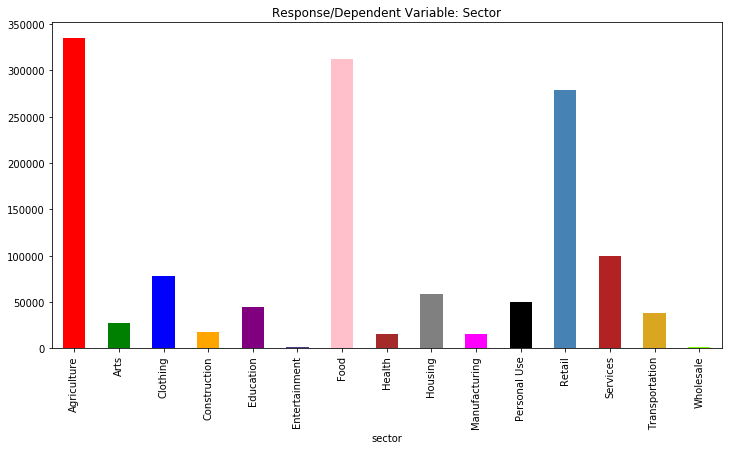

In [79]:
fig = plt.figure(figsize=(12,6))
df_final.groupby('sector').loan_description.count().plot.bar(ylim=0, color=['red', 'green', 'blue', 'orange', 'purple', 'darkslateblue', 'pink', 'brown', 'gray', 'magenta', 'black', 'steelblue', 'firebrick', 'goldenrod', 'lawngreen'])
plt.title("Response/Dependent Variable: Sector")
plt.savefig('imbalanced_classes.png')
plt.show()

In [16]:
df_final.sector.value_counts()/df_final.shape[0]*100

Agriculture       24.358689
Food              22.717431
Retail            20.249259
Services           7.237042
Clothing           5.694016
Housing            4.244646
Personal Use       3.613762
Education          3.249312
Transportation     2.754515
Arts               1.983765
Construction       1.317788
Health             1.169494
Manufacturing      1.117180
Wholesale          0.146986
Entertainment      0.146114
Name: sector, dtype: float64

In [17]:
df_final.query('sector == ["Entertainment", "Wholesale"]').shape

(4034, 3)

**Remove Sectors with <1% **

In [18]:
df2_final = df_final.query('sector != ["Entertainment", "Wholesale"]')

In [19]:
df2_final.shape

(1372288, 3)

In [20]:
df2_final.head()

,posted_time,loan_description,sector
0,2014-01-15 02:23:45,"Aivy, 21 years of age, is single and lives in ...",Retail
1,2014-01-14 20:23:20,"Idalia, 57, is married and lives with her husb...",Clothing
2,2014-01-16 11:32:58,Aasia is a 45-year-old married lady and she ha...,Retail
3,2014-01-20 09:59:48,Gulmira is 36 years old and married. She and ...,Agriculture
4,2014-01-14 05:46:21,Ricky is a farmer who currently cultivates his...,Agriculture


In [ ]:
data = df2_final.query('posted_time >= 2014 and posted_time < 2018')

**Attempted a CNN model but didn't yield good results...**

In [39]:
data['sector_id'] = data['sector'].factorize()[0]

In [40]:
data.head()

,posted_time,loan_description,sector,sector_id
0,2014-01-15 02:23:45,"Aivy, 21 years of age, is single and lives in ...",Retail,0
1,2014-01-14 20:23:20,"Idalia, 57, is married and lives with her husb...",Clothing,1
2,2014-01-16 11:32:58,Aasia is a 45-year-old married lady and she ha...,Retail,0
3,2014-01-20 09:59:48,Gulmira is 36 years old and married. She and ...,Agriculture,2
4,2014-01-14 05:46:21,Ricky is a farmer who currently cultivates his...,Agriculture,2


In [41]:
sector_id_df_final = data[['sector', 'sector_id']].drop_duplicates().sort_values('sector_id')
sector_to_id_final = dict(sector_id_df_final.values)
id_to_sector_final = dict(sector_id_df_final[['sector_id', 'sector']].values)

In [42]:
X_train, X_valid, y_train2, y_valid2 = train_test_split(data['loan_description'], data['sector_id'], random_state = 0)

In [43]:
X_train.shape, X_valid.shape, y_train2.shape, y_valid2.shape

((569721,), (189907,), (569721,), (189907,))

In [44]:
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

In [45]:
# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(data['loan_description'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(X_train), maxlen=100)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(X_valid), maxlen=100)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [46]:
print('x_train shape:', train_seq_x.shape)
print('x_test shape:', valid_seq_x.shape)

x_train shape: (569721, 100)
x_test shape: (189907, 100)


In [47]:
print('Build model...')
# Add an Input Layer
input_layer = layers.Input((100, ))

# Add the word embedding Layer
embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

# Add the convolutional Layer
conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

# Add the pooling Layer
pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

# Add the output Layers
output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
output_layer1 = layers.Dropout(0.25)(output_layer1)
output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

# Compile the model
model = models.Model(inputs=input_layer, outputs=output_layer2)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Build model...


In [48]:
print('Training model...')
model.fit(train_seq_x, y_train2)

Training model...
Epoch 1/1
569721/569721 [==============================] - 765s 1ms/step - loss: -35.8332 - acc: 0.0488


In [68]:
score = model.evaluate(valid_seq_x, y_valid2)

189907/189907 [==============================] - 61s 323us/step


In [70]:
predictions4 = model.predict(valid_seq_x)

In [71]:
predictions4 = predictions.argmax(axis=-1)

In [72]:
print('Test score: {:.3}'.format(score))

Test score: -35.9


In [73]:
accuracy_score(predictions4, y_valid2)

0.18546972992043473